🔍 Sample full-size TRAIN images:


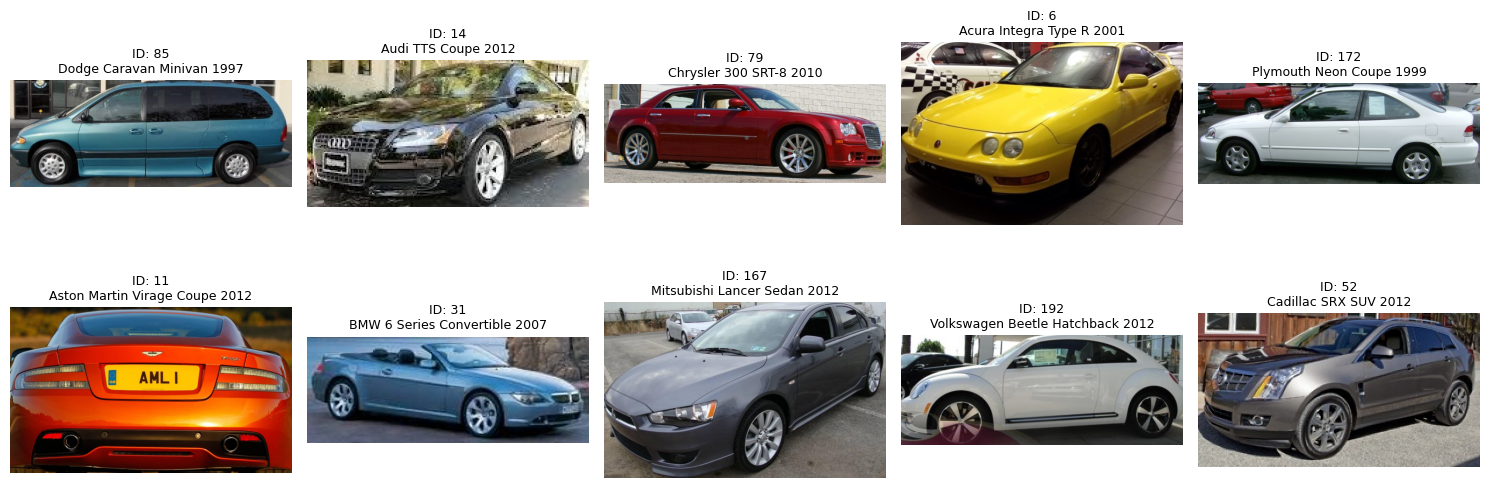

🔍 Sample full-size TEST images:


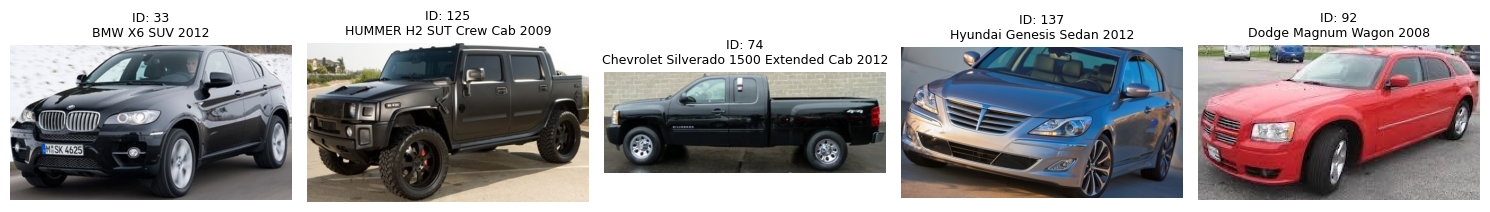

In [7]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# Step 1: Load annotations and extract class names
# ============================================
def build_filename_to_class_map(img_base_dir):
    """Create a mapping from filename to class folder name based on directory structure."""
    filename_to_class = {}
    for class_folder in os.listdir(img_base_dir):
        class_path = os.path.join(img_base_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            filename_to_class[fname] = class_folder
    return filename_to_class

def load_annotations(csv_path, img_base_dir):
    """Load annotations CSV and map images to their class folders."""
    df = pd.read_csv(csv_path)

    # Extract the base filename from the full path
    df['basename'] = df['path'].apply(lambda x: os.path.basename(str(x)))

    # Map base filenames to their corresponding class folder
    filename_to_class = build_filename_to_class_map(img_base_dir)
    df['class_name'] = df['basename'].map(filename_to_class)

    # Warn about missing images
    missing = df[df['class_name'].isnull()]
    if not missing.empty:
        print(f"⚠️ Warning: {len(missing)} images not found in directory structure.")
        print(missing['path'].head())

    return df

# ============================================
# Step 2: Display sample images
# ============================================
def show_images(df, base_dir, n=10, columns=5, cropped=False):
    """Display sample images with optional cropping and class labels."""
    df = df[df['class_name'].notnull()]  # Remove rows with unknown class

    rows = (n + columns - 1) // columns
    plt.figure(figsize=(columns * 3, rows * 3))

    sample_df = df.sample(n=min(n, len(df))).reset_index(drop=True)

    for i in range(len(sample_df)):
        row = sample_df.iloc[i]
        class_name = row['class_name']
        class_id = row.get('class_id', 'N/A')  # Use 'N/A' if class_id not present
        filename = row['basename']
        img_path = os.path.join(base_dir, class_name, filename)

        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read image: {img_path}")
            continue

        # Crop the image if coordinates are provided
        if cropped:
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            image = image[ymin:ymax, xmin:xmax]

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, columns, i + 1)
        plt.imshow(image)
        plt.title(f"ID: {class_id}\n{class_name}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# Paths
# ============================================
TRAIN_IMG_DIR = "/kaggle/input/croppedstanfordcardataset/train"
TEST_IMG_DIR = "/kaggle/input/croppedstanfordcardataset/test"
ANNO_TRAIN = "/kaggle/input/croppedstanfordcardataset/train.csv"
ANNO_TEST = "/kaggle/input/croppedstanfordcardataset/test.csv"

# Load annotations
train_df = load_annotations(ANNO_TRAIN, TRAIN_IMG_DIR)
test_df = load_annotations(ANNO_TEST, TEST_IMG_DIR)

# Show sample images
print("🔍 Sample full-size TRAIN images:")
show_images(train_df, TRAIN_IMG_DIR, n=10, columns=5, cropped=False)

print("🔍 Sample full-size TEST images:")
show_images(test_df, TEST_IMG_DIR, n=5, columns=5, cropped=False)


In [8]:
# Create class_name to class_id mapping
unique_classes = sorted(train_df['class_name'].dropna().unique())
class_to_id = {name: idx for idx, name in enumerate(unique_classes)}
train_df['class_id'] = train_df['class_name'].map(class_to_id)
test_df['class_id'] = test_df['class_name'].map(class_to_id)

In [9]:
train_df.head()

,path,class_id,class_name,basename
0,train/Audi TTS Coupe 2012/00001.jpg,23,Audi TTS Coupe 2012,00001.jpg
1,train/Acura TL Sedan 2012/00002.jpg,3,Acura TL Sedan 2012,00002.jpg
2,train/Dodge Dakota Club Cab 2007/00003.jpg,88,Dodge Dakota Club Cab 2007,00003.jpg
3,train/Hyundai Sonata Hybrid Sedan 2012/00004.jpg,135,Hyundai Sonata Hybrid Sedan 2012,00004.jpg
4,train/Ford F-450 Super Duty Crew Cab 2012/0000...,110,Ford F-450 Super Duty Crew Cab 2012,00005.jpg


In [10]:
test_df.head()

,path,class_id,class_name,basename
0,test/Suzuki Aerio Sedan 2007/00001.jpg,180,Suzuki Aerio Sedan 2007,00001.jpg
1,test/Ferrari 458 Italia Convertible 2012/00002...,100,Ferrari 458 Italia Convertible 2012,00002.jpg
2,test/Jeep Patriot SUV 2012/00003.jpg,147,Jeep Patriot SUV 2012,00003.jpg
3,test/Toyota Camry Sedan 2012/00004.jpg,186,Toyota Camry Sedan 2012,00004.jpg
4,test/Tesla Model S Sedan 2012/00005.jpg,184,Tesla Model S Sedan 2012,00005.jpg


🔍 Sample Train Images:


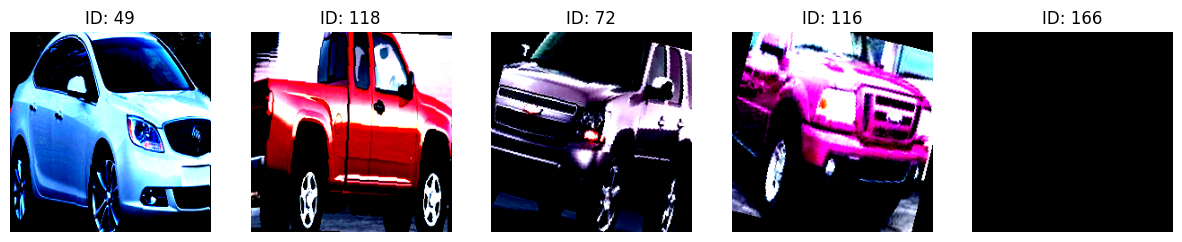

🔍 Sample Validation Images:


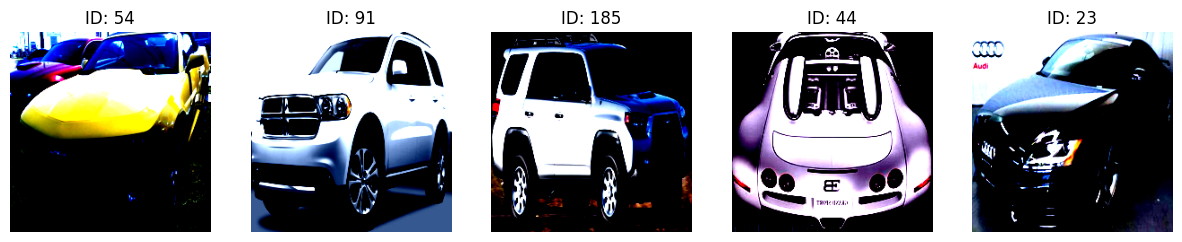

In [33]:
import os
import cv2
import pandas as pd
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

# ============================================
# Image Dataset Class (for DataLoader)
# ============================================
class ImageDataset(Dataset):
    def __init__(self, annotations_df, img_base_dir, transform=None):
        self.annotations_df = annotations_df
        self.img_base_dir = img_base_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        row = self.annotations_df.iloc[idx]
        class_id = row['class_id']
        filename = row['basename']  # از 'basename' به جای 'filename'
        img_path = os.path.join(self.img_base_dir, row['class_name'], filename)
        
        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply cropping if bounding box exists
        if 'xmin' in row and 'ymin' in row and 'xmax' in row and 'ymax' in row:
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            image = image[ymin:ymax, xmin:xmax]
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_id


# ============================================
# Image Transforms
# ============================================
image_size = (224, 224)  # Define your image size

image_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ])
}


# ============================================
# Load Annotations and Map Class Names to Class IDs
# ============================================
# Load the train and test annotations from CSV
train_df = load_annotations(ANNO_TRAIN, TRAIN_IMG_DIR)
test_df = load_annotations(ANNO_TEST, TEST_IMG_DIR)

# Create class_name to class_id mapping
unique_classes = sorted(train_df['class_name'].dropna().unique())
class_to_id = {name: idx for idx, name in enumerate(unique_classes)}
train_df['class_id'] = train_df['class_name'].map(class_to_id)
test_df['class_id'] = test_df['class_name'].map(class_to_id)

# ============================================
# Split Data into Train, Validation, and Test
# ============================================
train_percent = 1.0  # Adjust as necessary
val_percent = 1.0  # Adjust as necessary
test_percent = 1.0  # Adjust as necessary

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

# Apply sample fractions
train_df = train_df.sample(frac=train_percent, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=val_percent, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=test_percent, random_state=42).reset_index(drop=True)

# ============================================
# Create Datasets and DataLoaders
# ============================================
train_dataset = ImageDataset(train_df, TRAIN_IMG_DIR, transform=image_transforms['train'])
val_dataset = ImageDataset(val_df, TRAIN_IMG_DIR, transform=image_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# ============================================
# Display some sample images
# ============================================
def show_images_from_loader(loader, n=5):
    plt.figure(figsize=(15, 10))
    
    for i, (images, labels) in enumerate(loader):
        if i >= n:
            break
        for j in range(min(len(images), n)):  # Make sure you don't exceed the number of subplots
            ax = plt.subplot(1, n, j + 1)
            ax.imshow(images[j].permute(1, 2, 0))  # Convert tensor to HWC format for plotting
            ax.set_title(f"ID: {labels[j].item()}")
            ax.axis('off')  # Remove axis for better visualization
    plt.show()


# Show a few train images
print("🔍 Sample Train Images:")
show_images_from_loader(train_loader)

# Show a few validation images
print("🔍 Sample Validation Images:")
show_images_from_loader(val_loader)


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score

# CBAM Attention Module
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        )
        self.spatial_att = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)
        max_pool, _ = torch.max(x, dim=2, keepdim=True)
        max_pool, _ = torch.max(max_pool, dim=3, keepdim=True)
        channel_att = self.channel_att(avg_pool + max_pool).sigmoid()
        x = x * channel_att

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.spatial_att(torch.cat([avg_out, max_out], dim=1))
        return x * spatial_att


# Cross-Attention Mechanism
class CrossAttention(nn.Module):
    def __init__(self, d_model):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.scale = np.sqrt(d_model)

    def forward(self, x1, x2):
        q = self.query(x1)
        k = self.key(x2)
        v = self.value(x2)
        attn = torch.softmax(torch.bmm(q, k.transpose(1, 2)) / self.scale, dim=-1)
        return torch.bmm(attn, v)

# Hybrid Model Definition
class EfficientDense_CBAM_CrossAttention(nn.Module):
    def __init__(self, num_classes):
        super(EfficientDense_CBAM_CrossAttention, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.densenet = models.densenet121(pretrained=True)

        self.efficientnet.features[0].requires_grad = False
        self.densenet.features[0].requires_grad = False

        self.cbam_efficient = CBAM(1280)
        self.cbam_dense = CBAM(1024)

        self.cross_attention = CrossAttention(512)
        self.fc_efficient = nn.Linear(1280, 512)
        self.fc_dense = nn.Linear(1024, 512)

        self.classifier = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        fe = self.efficientnet.features(x)
        fd = self.densenet.features(x)

        fe = self.cbam_efficient(fe)
        fd = self.cbam_dense(fd)

        fe = F.adaptive_avg_pool2d(fe, (1, 1)).view(x.size(0), -1)
        fd = F.adaptive_avg_pool2d(fd, (1, 1)).view(x.size(0), -1)

        fe = self.fc_efficient(fe).unsqueeze(1)
        fd = self.fc_dense(fd).unsqueeze(1)

        cross_attended = self.cross_attention(fe, fd).squeeze(1)
        out = self.dropout(cross_attended)
        return self.classifier(out)

# Top-K Accuracy

def calculate_top_k_accuracy(output, target, k=5):
    _, pred = output.topk(k, dim=1)
    correct = pred.eq(target.view(-1, 1).expand_as(pred))
    return correct.any(dim=1).float().mean().item()

# Training Function
def train(model, criterion, optimizer, train_loader, val_loader, save_location,
          early_stop=3, n_epochs=1, print_every=1, scheduler=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    valid_loss_min = np.inf
    stop_count = 0
    best_epoch = 0
    best_top5_acc = 0
    history = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_top1, train_top5 = 0, 0, 0
        train_labels, train_preds = [], []

        for data, label in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = output.max(1)
            train_top1 += pred.eq(label).sum().item()
            train_top5 += calculate_top_k_accuracy(output, label, k=5) * data.size(0)

            train_labels.extend(label.cpu().numpy())
            train_preds.extend(pred.cpu().numpy())

        val_loss, val_top1, val_top5 = 0, 0, 0
        val_labels, val_preds = [], []
        model.eval()

        with torch.no_grad():
            for data, label in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val"):
                data, label = data.to(device), label.to(device)
                output = model(data)
                loss = criterion(output, label)

                val_loss += loss.item() * data.size(0)
                _, pred = output.max(1)
                val_top1 += pred.eq(label).sum().item()
                val_top5 += calculate_top_k_accuracy(output, label, k=5) * data.size(0)

                val_labels.extend(label.cpu().numpy())
                val_preds.extend(pred.cpu().numpy())

        num_train = len(train_loader.dataset)
        num_val = len(val_loader.dataset)

        history.append([
            train_loss / num_train,
            val_loss / num_val,
            train_top1 / num_train,
            val_top1 / num_val,
            train_top5 / num_train,
            val_top5 / num_val
        ])

        if (epoch + 1) % print_every == 0:
            print(f"\nEpoch {epoch+1}: Train Loss: {train_loss/num_train:.4f} | Val Loss: {val_loss/num_val:.4f}")
            print(f"Top-1 Train Acc: {(train_top1 / num_train)*100:.2f}%, Top-5: {(train_top5 / num_train)*100:.2f}%")
            print(f"Top-1 Val Acc: {(val_top1 / num_val)*100:.2f}%, Top-5: {(val_top5 / num_val)*100:.2f}%")
            print(f"Train Precision: {precision_score(train_labels, train_preds, average='macro', zero_division=1):.2f} | Recall: {recall_score(train_labels, train_preds, average='macro', zero_division=1):.2f}")
            print(f"Val Precision: {precision_score(val_labels, val_preds, average='macro', zero_division=1):.2f} | Recall: {recall_score(val_labels, val_preds, average='macro', zero_division=1):.2f}")

        if scheduler is not None:
            scheduler.step()

        if val_loss < valid_loss_min:
            torch.save({'state_dict': model.state_dict()}, save_location)
            valid_loss_min = val_loss
            best_top5_acc = val_top5 / num_val
            best_epoch = epoch
            stop_count = 0
        else:
            stop_count += 1
            if stop_count >= early_stop:
                print(f"\nEarly stopping at epoch {epoch+1}. Best Top-5 Acc: {best_top5_acc*100:.2f}%")
                model.load_state_dict(torch.load(save_location)['state_dict'])
                return model, pd.DataFrame(history, columns=[
                    'train_loss', 'val_loss',
                    'train_top1_acc', 'val_top1_acc',
                    'train_top5_acc', 'val_top5_acc'
                ])

    print(f"\nTraining complete. Best epoch: {best_epoch} with Top-5 Acc: {best_top5_acc*100:.2f}%")
    return model, pd.DataFrame(history, columns=[
        'train_loss', 'val_loss',
        'train_top1_acc', 'val_top1_acc',
        'train_top5_acc', 'val_top5_acc'
    ])

# --- Run Setup ---

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

n_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = EfficientDense_CBAM_CrossAttention(num_classes=196)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

model, history = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    save_location='efficient_dense_cbam_crossattention.pt',
    early_stop=4,
    n_epochs=n_epochs,
    scheduler=scheduler,
    print_every=1
)

Using device: cuda
Using 2 GPUs


Epoch 1 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s]



Epoch 1: Train Loss: 4.5520 | Val Loss: 3.2823
Top-1 Train Acc: 6.60%, Top-5: 20.49%
Top-1 Val Acc: 18.54%, Top-5: 50.15%
Train Precision: 0.08 | Recall: 0.06
Val Precision: 0.58 | Recall: 0.20


Epoch 2 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.41it/s]



Epoch 2: Train Loss: 2.7352 | Val Loss: 1.8251
Top-1 Train Acc: 30.13%, Top-5: 63.94%
Top-1 Val Acc: 49.42%, Top-5: 83.30%
Train Precision: 0.29 | Recall: 0.30
Val Precision: 0.64 | Recall: 0.50


Epoch 3 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.49it/s]



Epoch 3: Train Loss: 1.6686 | Val Loss: 1.2919
Top-1 Train Acc: 53.81%, Top-5: 85.19%
Top-1 Val Acc: 63.60%, Top-5: 89.63%
Train Precision: 0.53 | Recall: 0.53
Val Precision: 0.73 | Recall: 0.64


Epoch 4 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.51it/s]



Epoch 4: Train Loss: 1.1393 | Val Loss: 1.0806
Top-1 Train Acc: 66.40%, Top-5: 92.66%
Top-1 Val Acc: 67.96%, Top-5: 92.88%
Train Precision: 0.66 | Recall: 0.66
Val Precision: 0.75 | Recall: 0.70


Epoch 5 - Val: 100%|██████████| 51/51 [00:15<00:00,  3.39it/s]



Epoch 5: Train Loss: 0.7918 | Val Loss: 0.8159
Top-1 Train Acc: 76.30%, Top-5: 96.25%
Top-1 Val Acc: 76.18%, Top-5: 95.15%
Train Precision: 0.76 | Recall: 0.76
Val Precision: 0.80 | Recall: 0.78


Epoch 6 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]



Epoch 6: Train Loss: 0.5934 | Val Loss: 0.7244
Top-1 Train Acc: 81.80%, Top-5: 98.14%
Top-1 Val Acc: 79.68%, Top-5: 96.07%
Train Precision: 0.82 | Recall: 0.81
Val Precision: 0.83 | Recall: 0.81


Epoch 7 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.44it/s]



Epoch 7: Train Loss: 0.4494 | Val Loss: 0.7227
Top-1 Train Acc: 86.26%, Top-5: 98.91%
Top-1 Val Acc: 80.17%, Top-5: 95.58%
Train Precision: 0.86 | Recall: 0.86
Val Precision: 0.82 | Recall: 0.81


Epoch 8 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.46it/s]



Epoch 8: Train Loss: 0.3547 | Val Loss: 0.6279
Top-1 Train Acc: 89.06%, Top-5: 99.22%
Top-1 Val Acc: 82.50%, Top-5: 96.44%
Train Precision: 0.89 | Recall: 0.89
Val Precision: 0.85 | Recall: 0.83


Epoch 9 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.50it/s]



Epoch 9: Train Loss: 0.2725 | Val Loss: 0.6165
Top-1 Train Acc: 91.39%, Top-5: 99.59%
Top-1 Val Acc: 83.43%, Top-5: 96.19%
Train Precision: 0.91 | Recall: 0.91
Val Precision: 0.86 | Recall: 0.84


Epoch 10 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.46it/s]



Epoch 10: Train Loss: 0.2391 | Val Loss: 0.5905
Top-1 Train Acc: 92.14%, Top-5: 99.71%
Top-1 Val Acc: 84.53%, Top-5: 96.69%
Train Precision: 0.92 | Recall: 0.92
Val Precision: 0.87 | Recall: 0.86


Epoch 11 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.48it/s]



Epoch 11: Train Loss: 0.1725 | Val Loss: 0.5219
Top-1 Train Acc: 94.67%, Top-5: 99.79%
Top-1 Val Acc: 86.62%, Top-5: 97.61%
Train Precision: 0.95 | Recall: 0.94
Val Precision: 0.89 | Recall: 0.87


Epoch 12 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.43it/s]



Epoch 12: Train Loss: 0.1294 | Val Loss: 0.4812
Top-1 Train Acc: 96.27%, Top-5: 99.91%
Top-1 Val Acc: 86.37%, Top-5: 97.85%
Train Precision: 0.96 | Recall: 0.96
Val Precision: 0.88 | Recall: 0.87


Epoch 13 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.42it/s]



Epoch 13: Train Loss: 0.0968 | Val Loss: 0.5136
Top-1 Train Acc: 97.19%, Top-5: 99.95%
Top-1 Val Acc: 86.62%, Top-5: 97.85%
Train Precision: 0.97 | Recall: 0.97
Val Precision: 0.88 | Recall: 0.88


Epoch 14 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.49it/s]



Epoch 14: Train Loss: 0.0792 | Val Loss: 0.4841
Top-1 Train Acc: 97.67%, Top-5: 99.97%
Top-1 Val Acc: 87.54%, Top-5: 97.79%
Train Precision: 0.98 | Recall: 0.98
Val Precision: 0.89 | Recall: 0.88


Epoch 15 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.40it/s]



Epoch 15: Train Loss: 0.0690 | Val Loss: 0.4818
Top-1 Train Acc: 97.91%, Top-5: 100.00%
Top-1 Val Acc: 87.23%, Top-5: 97.79%
Train Precision: 0.98 | Recall: 0.98
Val Precision: 0.89 | Recall: 0.88


Epoch 16 - Val: 100%|██████████| 51/51 [00:14<00:00,  3.45it/s]
/tmp/ipykernel_31/3842919240.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc


Epoch 16: Train Loss: 0.0607 | Val Loss: 0.4851
Top-1 Train Acc: 98.04%, Top-5: 99.98%
Top-1 Val Acc: 87.48%, Top-5: 97.54%
Train Precision: 0.98 | Recall: 0.98
Val Precision: 0.89 | Recall: 0.88

Early stopping at epoch 16. Best Top-5 Acc: 97.85%


In [66]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

# Define Dataset for test data
class TestDataset(Dataset):
    def __init__(self, df, transform=None, base_path='/kaggle/input/croppedstanfordcardataset/'):
        self.df = df
        self.transform = transform
        self.base_path = base_path  # Base path for image file paths

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Add base path to the image file path
        img_path = self.base_path + self.df.iloc[idx, 0]
        img = Image.open(img_path).convert("RGB")
        label = self.df.iloc[idx, 1]
        
        # Apply the transformation to the image if provided
        if self.transform:
            img = self.transform(img)
        
        return img, label


# Test transformation for images
image_size = 224  # Image size should match model's expected input size
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize image to required size
    transforms.CenterCrop(image_size),  # Crop image to center
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Normalize image
])

# Create DataLoader for test data
test_dataset = TestDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test function for the model
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Testing"):
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            _, preds = output.max(1)  # Get predicted class labels
            all_preds.extend(preds.cpu().numpy())  # Convert to numpy array
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy array

    return np.array(all_preds), np.array(all_labels)

# Run the test function on the test data
preds, labels = test(model, test_loader)

# Display the accuracy of the model on the test data
print(f"Test Accuracy: {accuracy_score(labels, preds) * 100:.2f}%")


Testing: 100%|██████████| 252/252 [01:32<00:00,  2.74it/s]

Test Accuracy: 0.65%


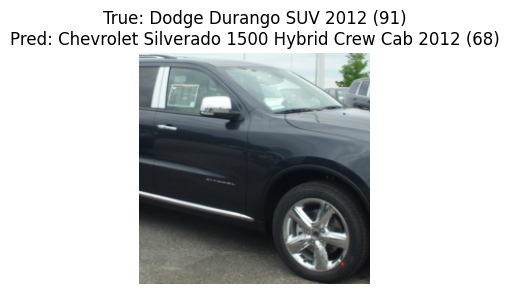

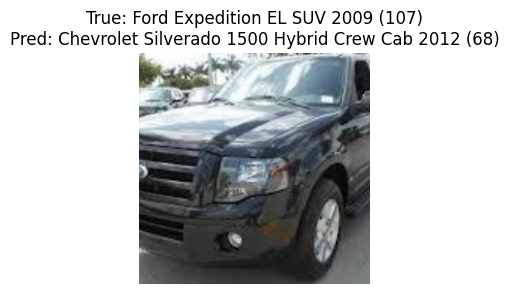

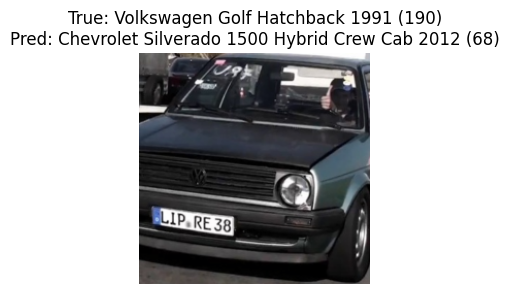

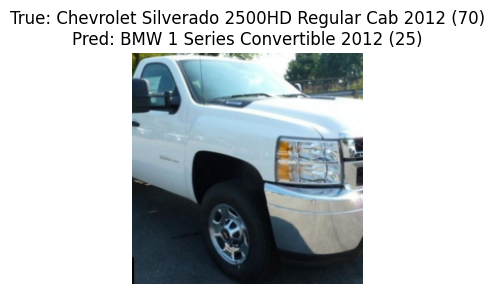

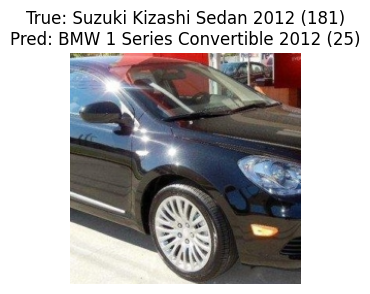

In [67]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Number of images you want to display
num_images_to_show = 5

# Function to display images along with predictions and true labels
def show_images_with_predictions(test_loader, preds, labels, class_names, num_images=10):
    # Set the model to evaluation mode
    model.eval()
    
    # Randomly select `num_images` indices from the test set
    random_indices = random.sample(range(len(test_loader.dataset)), num_images)

    images_shown = 0
    for idx in random_indices:
        # Get the image and true label from the test loader using the random index
        data, true_labels = test_loader.dataset[idx]
        
        # Get prediction for the current image
        predicted_label = preds[idx]
        true_label = true_labels
        
        # Reverse the normalization applied during preprocessing
        img = data.cpu().numpy().transpose((1, 2, 0))  # Convert image to displayable format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Reverse normalization
        img = np.clip(img, 0, 1)  # Ensure the values are within the [0, 1] range
        
        # Get the class id and class name for true and predicted labels
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]

        # Display image and details
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(f"True: {true_class_name} ({true_label})\nPred: {predicted_class_name} ({predicted_label})")
        plt.axis('off')
        plt.show()

        images_shown += 1

# Assuming you have class_names as a list of class names corresponding to class ids
# Create a dictionary that maps class_id to class_name from the test_df
class_names = {row['class_id']: row['class_name'] for _, row in test_df.iterrows()}

# Display n random images from the test set along with predictions and true labels
show_images_with_predictions(test_loader, preds, labels, class_names, num_images=num_images_to_show)
